# Intro

This notebook is used to train classifiers to predict used memory, and then save the trained model along with the data it used. This includes a decision tree, a random forest, a gradient boosted decision tree model, and a logistic regressor.

# Notebook options

The grid_search parameter determines whether the notebook will execute a grid search for each model to find the best combination of hyperparameters, or whether the notebook will just use some pre-set parameters (which were found in previous grid searches).

The save_model parameter determines whether to save a model at the end (currently it saves the random forest model).

The training_mode parameter can either be 'normal', 'test', or 'final'.

In [1]:
grid_search = False
save_model = True
training_mode = 'test'

# Imports

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from hypopt import GridSearch
from datetime import datetime
from datetime import date
from preprocessing import get_df
from preprocessing import scale
from persistence import model_saver
from evaluation import score_model
from evaluation import print_feature_importances
from evaluation import plot_performance
from evaluation import plot_cm
from evaluation import print_cr
from evaluation import auc
import time

In [3]:
from sklearn.metrics import make_scorer

In [4]:
df = get_df()

In [27]:
df.sort_values(by='used_mem', ascending=False).head(20)

,request_type,job_start_at,job_end_at,req_mem,used_mem,dsnum,rqst_start_at,rqst_end_at,dates_init,slat,...,PP,SP,BR,converted,ds084.1,ds631.1,ds083.3,ds094.0,ds083.2,mem_category
6409671,SP,2021-01-19 20:03:21,2021-01-20 04:14:48,51200.0,46016.789062,084.1,2019-03-20 00:00:00+00:00,2020-03-20 23:00:00+00:00,False,28.0,...,False,True,False,False,True,False,False,False,False,8
6368723,SP,2021-01-08 15:23:19,2021-01-08 16:19:11,51200.0,44637.320312,084.1,2017-12-31 00:00:00+00:00,2019-01-01 00:00:00+00:00,False,NaN,...,False,True,False,False,True,False,False,False,False,8
6316991,SP,2020-12-21 21:09:22,2020-12-21 22:00:36,51200.0,44069.371094,084.1,2017-12-31 00:00:00+00:00,2019-01-01 00:00:00+00:00,False,NaN,...,False,True,False,False,True,False,False,False,False,8
6376670,SP,2021-01-12 08:49:12,2021-01-12 10:03:10,51200.0,43421.906250,084.1,2017-12-31 00:00:00+00:00,2019-01-01 00:00:00+00:00,False,NaN,...,False,True,False,False,True,False,False,False,False,8
6180321,SP,2020-11-11 02:33:04,2020-11-11 02:57:55,51200.0,42468.195312,084.1,2016-01-01 00:00:00+00:00,2016-12-31 18:00:00+00:00,False,NaN,...,False,True,False,False,True,False,False,False,False,8
6526875,SP,2021-02-19 09:10:06,2021-02-19 11:32:32,51200.0,42424.316406,084.1,2020-01-01 00:00:00+00:00,2020-12-31 12:00:00+00:00,False,23.0,...,False,True,False,False,True,False,False,False,False,8
6319427,SP,2020-12-22 11:29:41,2020-12-22 12:53:20,51200.0,40603.265625,084.1,2017-12-31 00:00:00+00:00,2019-01-01 00:00:00+00:00,False,NaN,...,False,True,False,False,True,False,False,False,False,8
6241485,SP,2020-12-02 12:27:06,2020-12-02 16:32:38,40960.0,39062.500000,626.0,1900-01-01 00:00:00+00:00,2010-12-31 21:00:00+00:00,False,NaN,...,False,True,False,True,False,False,False,False,False,8
6521452,SP,2021-02-17 15:27:53,2021-02-17 18:05:06,51200.0,36603.878906,084.1,2020-01-01 00:00:00+00:00,2020-12-31 12:00:00+00:00,False,23.0,...,False,True,False,False,True,False,False,False,False,8
6226787,SP,2020-11-29 01:12:08,2020-11-29 02:14:45,30720.0,30719.984375,628.0,1957-12-31 21:00:00+00:00,2020-11-01 00:00:00+00:00,False,NaN,...,False,True,False,True,False,False,False,False,False,8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   request_type     50360 non-null  object             
 1   job_start_at     50360 non-null  datetime64[ns]     
 2   job_end_at       50360 non-null  datetime64[ns]     
 3   req_mem          50360 non-null  float64            
 4   used_mem         50360 non-null  float64            
 5   dsnum            48150 non-null  object             
 6   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 7   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 8   dates_init       50360 non-null  bool               
 9   slat             32123 non-null  float64            
 10  nlat             32123 non-null  float64            
 11  wlon             32140 non-null  float64            
 12  elon             32140 non-null  float64            
 13  gui     

In [6]:
mem_bin_cutoffs = [50, 100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
num_classes = len(mem_bin_cutoffs)
bin_sizes = [df[df.used_mem < mem_bin_cutoffs[0]].shape[0]]
for i in range(1, len(mem_bin_cutoffs)):
    current_bin_size = df[(df.used_mem >= mem_bin_cutoffs[i-1])
                        & (df.used_mem < mem_bin_cutoffs[i])].shape[0]
    bin_sizes.append(current_bin_size)

In [7]:
def print_mem_categories():
    print(f"0: < {mem_bin_cutoffs[0]}MB ({bin_sizes[0]} entries)")
    for i in range(1, len(mem_bin_cutoffs)):
        print(f"{i}: >= {mem_bin_cutoffs[i-1]}MB"
              + f" and < {mem_bin_cutoffs[i]}MB"
              + f" ({bin_sizes[i]} entries)")

In [8]:
print_mem_categories()

0: < 50MB (22965 entries)
1: >= 50MB and < 100MB (11126 entries)
2: >= 100MB and < 200MB (8623 entries)
3: >= 200MB and < 500MB (3169 entries)
4: >= 500MB and < 1000MB (1639 entries)
5: >= 1000MB and < 2000MB (2535 entries)
6: >= 2000MB and < 10000MB (248 entries)
7: >= 10000MB and < 20000MB (33 entries)
8: >= 20000MB and < 50000MB (22 entries)
9: >= 50000MB and < 100000MB (0 entries)


In [9]:
def mem_category(row):
    mem = row['used_mem']
    if mem < mem_bin_cutoffs[0]:
        return 0
    for i in range(1, len(mem_bin_cutoffs)):
        if mem >= mem_bin_cutoffs[i-1] and mem < mem_bin_cutoffs[i]:
            return i
    return None

In [10]:
df['mem_category'] = df.apply(lambda row: mem_category(row), axis=1)

In [11]:
df = df[df.rqst_timespan.notnull() & df.rqst_area_rect.notnull()]
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['req_mem', 'used_mem', 'mem_category']

X = df[X_features]
y = df[y_features]

## Train/validation/test split

In [12]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

In [13]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test, y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)

In [14]:
y_train = np.ravel(y_train_full['mem_category'])
y_val = np.ravel(y_val_full['mem_category'])
y_test = np.ravel(y_test_full['mem_category'])

## Scaling

In [15]:
X_train_norm, X_val_norm, X_test_norm = \
    scale(X_train, X_val, X_test)

In [16]:
def balanced_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = n_samples / ((num_classes - 1) * (np.bincount(y_train)))
    
    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

balanced_scorer = make_scorer(score_func=balanced_score,
                              greater_is_better=True)

## Trees, Forest, Gradient Boosts

### Tree

In [17]:
if grid_search:
    tree_param_grid = {'random_state':[3], 'max_depth':range(2,20),
                       'min_samples_split':range(2,8),
                       'class_weight':['balanced']}
    tree_gs = GridSearch(model=DecisionTreeClassifier(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, y_train, X_val_norm, y_val, scoring=balanced_scorer)
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_

else:
    tree = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=19, random_state=3)
    tree.fit(X_train_norm, y_train)

### Forest

In [18]:
if grid_search:
    start = time.time()
    forest_param_grid = {'random_state':[3],
                               'max_depth':range(2,20),
                               'min_samples_split':range(2,10),
                               'n_estimators':[50,100,150,200,250],
                               'n_jobs':[8],
                               'class_weight':['balanced']}
    forest_gs = GridSearch(model=RandomForestClassifier(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, y_train, X_val_norm, y_val,
                  scoring=balanced_scorer)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
else:
    forest = RandomForestClassifier(class_weight='balanced',
                                      max_depth=16,
                                      min_samples_split=9,
                                      n_estimators=50,
                                      random_state=3)
    forest.fit(X_train_norm, y_train)

In [19]:
if training_mode == 'test':
    new_X_train = np.concatenate((X_train_norm, X_val_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full])['mem_category'])
    forest.fit(new_X_train, new_y_train)
elif training_mode == 'final':
    new_X_train = np.concatenate((X_train_norm,
                                  X_val_norm,
                                  X_test_norm))
    new_y_train = np.ravel(pd.concat([y_train_full,
                                      y_val_full,
                                      y_test_full])['mem_category'])
    forest.fit(new_X_train, new_y_train)

### Gradient boosted trees

In [20]:
if grid_search:
    gboost_param_grid = {'random_state':[3],
                               'max_depth':range(2,15),
                               'n_estimators':[100,200,300,500]}
    gboost_gs = GridSearch(model=GradientBoostingClassifier(), 
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(class_gboost_gs.best_params)
    class_gboost = class_gboost_gs.best_estimator_
else:
    gboost = GradientBoostingClassifier(random_state=3,
                                        max_depth=14,
                                        n_estimators=150)
    #gboost.fit(X_train_norm, y_train)

## Linear regressors

In [21]:
logist = LogisticRegression(max_iter=100, class_weight='balanced')
#logist.fit(X_train_norm, y_train)

In [22]:
notes = "Class forest, filling missing lat/lon with max value. " \
         + "Trained on train + val" \
         + "Grid searched on Casper Batch job. " \
         + "X values NOT scaled."

In [23]:
if save_model:
    ms = model_saver('class_forest_test', notes,
                   forest, df, 
                   X_features,
                   X_train, y_train_full,
                   X_val, y_val_full,
                   X_test, y_test_full)
    ms.save()

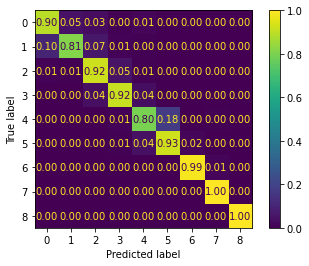

In [24]:
plot_cm(X_val=X_val_norm, y_val=y_val, model=forest)

In [25]:
print_cr(X_val_norm, y_val, forest)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      5653
           1       0.89      0.81      0.85      2831
           2       0.83      0.92      0.87      2142
           3       0.81      0.92      0.86       792
           4       0.67      0.80      0.73       410
           5       0.87      0.93      0.90       648
           6       0.73      0.99      0.84        67
           7       0.23      1.00      0.38         3
           8       0.80      1.00      0.89         8

    accuracy                           0.88     12554
   macro avg       0.75      0.92      0.80     12554
weighted avg       0.89      0.88      0.88     12554

